<a href="https://colab.research.google.com/github/jwtan0421/ai_llm/blob/main/12-fine-tuning-01/index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# if package errors, try below
!pip cache purge
!pip install accelerate -U
!pip install transformers[torch]
!pip install datasets

Files removed: 39
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 87.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 18.0 MB/s eta 0:00:00


In [2]:
import datasets
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
from transformers import AutoModelForCausalLM
from transformers import TrainingArguments, Seq2SeqTrainingArguments
from transformers import Trainer, Seq2SeqTrainer
import transformers
from transformers import DataCollatorWithPadding
from transformers import TextGenerationPipeline
import torch
import numpy as np
import os, re
from tqdm import tqdm
import torch.nn as nn

In [3]:
MAX_LEN=32           # 最大长度
SEED=42             # 随机种子
LR=2e-5             # 学习率
BATCH_SIZE=8          # BATCH_SIZE
WARMUP_RATIO=0.1        # warmup比例
INTERVAL=100          # 每多少步打一次 log / 做一次 eval

In [4]:
MODEL_NAME = "gpt2"                     # 模型名称
# MODEL_NAME = "gpt2-large"

In [5]:
DATASET_NAME = "rotten_tomatoes"        # 数据集名称
DATA_BODY_KEY = "text"
DATA_LABEL_KEY = "label"

In [6]:
# 加载数据集
raw_datasets = load_dataset(DATASET_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [7]:
# 训练集
raw_train_dataset = raw_datasets["train"]

In [8]:
# 验证集
raw_valid_dataset = raw_datasets["validation"]

In [9]:
columns = raw_train_dataset.column_names

In [10]:
import json


def print_json(data):
    """
    打印参数。如果参数是有结构的（如字典或列表），则以格式化的 JSON 形式打印；
    否则，直接打印该值。
    """
    if hasattr(data, 'model_dump_json'):
        data = json.loads(data.model_dump_json())

    if (isinstance(data, (list))):
        for item in data:
            print_json(item)
    elif (isinstance(data, (dict))):
        print(json.dumps(
            data,
            indent=4,
            ensure_ascii=False
        ))
    else:
        print(data)

In [12]:
print_json(raw_train_dataset[:2])

{
    "text": [
        "the rock is destined to be the 21st century's new \" conan \" and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .",
        "the gorgeously elaborate continuation of \" the lord of the rings \" trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson's expanded vision of j . r . r . tolkien's middle-earth ."
    ],
    "label": [
        1,
        1
    ]
}


In [13]:
# 设置随机种子
transformers.set_seed(SEED)

In [14]:
# 定义tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME,trust_remote_code=True)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
tokenizer.pad_token_id = 0

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [15]:
named_labels = ['neg','pos']

In [16]:
# 标签转 token_id
label_ids = [
    tokenizer(named_labels[i],add_special_tokens=False)["input_ids"][0]
    for i in range(len(named_labels))
]

In [17]:
label_ids

[12480, 1930]

In [18]:
# 定义数据处理函数，把原始数据转成input_ids, attention_mask, labels
def process_fn(examples):
    model_inputs = {
            "input_ids": [],
            "attention_mask": [],
            "labels": [],
        }
    for i in range(len(examples[DATA_BODY_KEY])):
        inputs = tokenizer(examples[DATA_BODY_KEY][i],add_special_tokens=False)
        label = label_ids[examples[DATA_LABEL_KEY][i]]
        input_ids = inputs["input_ids"] + [tokenizer.eos_token_id, label]

        raw_len = len(input_ids)
        input_len = len(inputs["input_ids"]) + 1

        if raw_len >= MAX_LEN:
            input_ids = input_ids[-MAX_LEN:]
            attention_mask = [1] * MAX_LEN
            labels = [-100]*(MAX_LEN - 1) + [label]
        else:
            input_ids = input_ids + [tokenizer.pad_token_id] * (MAX_LEN - raw_len)
            attention_mask = [1] * raw_len + [0] * (MAX_LEN - raw_len)
            labels = [-100]*input_len + [label] + [-100] * (MAX_LEN - raw_len)
        model_inputs["input_ids"].append(input_ids)
        model_inputs["attention_mask"].append(attention_mask)
        model_inputs["labels"].append(labels)
    return model_inputs

In [19]:
# 处理训练数据集
tokenized_train_dataset = raw_train_dataset.map(
    process_fn,
    batched=True,
    remove_columns=columns,
    desc="Running tokenizer on train dataset",
)

Running tokenizer on train dataset:   0%|          | 0/8530 [00:00<?, ? examples/s]

In [20]:
# 处理验证数据集
tokenized_valid_dataset = raw_valid_dataset.map(
    process_fn,
    batched=True,
    remove_columns=columns,
    desc="Running tokenizer on validation dataset",
)

Running tokenizer on validation dataset:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [21]:
# 定义数据校准器（自动生成batch）
collater = DataCollatorWithPadding(
    tokenizer=tokenizer, return_tensors="pt",
)

In [22]:
# 定义模型
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME,trust_remote_code=True)
# 节省显存
model.gradient_checkpointing_enable()

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [23]:
# 定义训练参数
training_args = TrainingArguments(
    output_dir="./output",              # checkpoint保存路径
    evaluation_strategy="steps",        # 按步数计算eval频率
    overwrite_output_dir=True,
    num_train_epochs=1,                 # 训练epoch数
    per_device_train_batch_size=BATCH_SIZE,     # 每张卡的batch大小
    gradient_accumulation_steps=1,              # 累加几个step做一次参数更新
    per_device_eval_batch_size=BATCH_SIZE,      # evaluation batch size
    eval_steps=INTERVAL,                # 每N步eval一次
    logging_steps=INTERVAL,             # 每N步log一次
    save_steps=INTERVAL,                # 每N步保存一个checkpoint
    learning_rate=LR,                   # 学习率
    warmup_ratio=WARMUP_RATIO,          # warmup比例
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [24]:
def compute_metric(eval_predictions):
    predictions, labels = eval_predictions

    label_indices = (labels != -100).nonzero()
    actual_labels = labels[label_indices]

    label_indices = (label_indices[0], label_indices[1]-1)
    selected_logits = predictions[label_indices]

    predicted_labels = selected_logits[:,label_ids].argmax(axis=-1)

    predicted_labels = np.array(label_ids)[predicted_labels]

    correct_predictions = (predicted_labels == actual_labels).sum()

    accuracy = correct_predictions / len(labels)

    return { "acc" : accuracy }

In [25]:
# 定义训练器
trainer = Trainer(
    model=model, # 待训练模型
    args=training_args, # 训练参数
    data_collator=collater, # 数据校准器
    train_dataset=tokenized_train_dataset,  # 训练集
    eval_dataset=tokenized_valid_dataset,   # 验证集
    # compute_metrics=compute_metric,         # 计算自定义指标
)

In [26]:
# 开始训练
trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss,Validation Loss
100,5.290700,0.706875
200,0.759700,0.593242
300,0.599000,0.414646
400,0.496000,0.499310
500,0.456000,0.397530
600,0.503600,0.367613
700,0.430800,0.391807
800,0.460400,0.369734
900,0.421300,0.380100
1000,0.414700,0.362389


TrainOutput(global_step=1067, training_loss=0.9454252462914421, metrics={'train_runtime': 183.5177, 'train_samples_per_second': 46.481, 'train_steps_per_second': 5.814, 'total_flos': 139301314560000.0, 'train_loss': 0.9454252462914421, 'epoch': 1.0})

In [27]:
from logging import log
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import logging
logging.get_logger("transformers").setLevel(logging.ERROR)

# 加载训练后的 checkpoint
model = AutoModelForCausalLM.from_pretrained("output/checkpoint-1000")

# 模型设为推理模式
model.eval()

# 加载 tokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")

while True:
  # 待分类文本
  text = input("Please input your reviews: ")

  if text.strip() == "":
    break

  # 文本转 token ids - 记得以 eos 标识输入结束，与训练时一样
  inputs = tokenizer(text+tokenizer.eos_token, return_tensors="pt")

  # 推理：预测标签
  output = model.generate(**inputs, do_sample=False, max_new_tokens=1)

  # label token 转标签文本
  label = tokenizer.decode(output[0][-1])

  print(f"Sentiment: {label}")


Please input your reviews: 这部电影不好看
Sentiment: neg
Please input your reviews: 这部电影很好
Sentiment: neg
Please input your reviews: This movie is nice
Sentiment: pos
Please input your reviews: This movie is not good 
Sentiment: neg
Please input your reviews: 


In [28]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

BATCH_SIZE = 64
TEST_BACTH_SIZE = 1000
EPOCHS = 60
LR = 0.01
SEED = 42
LOG_INTERVAL = 100
loss_arr = []
acc_arr = []

# 定义一个全连接网络
class FeedForwardNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 第一层784维输入、256维输出 -- 图像大小28×28=784
        self.fc1 = nn.Linear(784, 256)
        # 第二层256维输入、128维输出
        self.fc2 = nn.Linear(256, 128)
        # 第三层128维输入、64维输出
        self.fc3 = nn.Linear(128, 64)
        # 第四层64维输入、10维输出 -- 输出类别10类（0,1,...9）
        self.fc4 = nn.Linear(64, 10)

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # 把输入展平成1D向量
        x = x.view(x.shape[0], -1)

        # 每层激活函数是ReLU，额外加dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # 输出为10维概率分布
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

# 训练过程
def train(model, loss_fn, device, train_loader, optimizer, epoch):
    # 开启梯度计算
    model.train()
    for batch_idx, (data_input, true_label) in enumerate(train_loader):
        # 从数据加载器读取一个batch
        # 把数据上载到GPU（如有）
        data_input, true_label = data_input.to(device), true_label.to(device)
        # 求解器初始化（每个batch初始化一次）
        optimizer.zero_grad()
        # 正向传播：模型由输入预测输出
        output = model(data_input)
        # 计算loss
        loss = loss_fn(output, true_label)
        # 反向传播：计算当前batch的loss的梯度
        loss.backward()
        # 由求解器根据梯度更新模型参数
        optimizer.step()

        # 间隔性的输出当前batch的训练loss
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data_input), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


# 计算在测试集的准确率和loss
def test(model, loss_fn, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # sum up batch loss
            test_loss += loss_fn(output, target, reduction='sum').item()
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    acc_val = 100. * correct / len(test_loader.dataset)

    loss_arr.append(test_loss)
    acc_arr.append(acc_val)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), acc_val))


def main():
    # 检查是否有GPU
    use_cuda = torch.cuda.is_available()

    # 设置随机种子（以保证结果可复现）
    torch.manual_seed(SEED)

    # 训练设备（GPU或CPU）
    device = torch.device("cuda" if use_cuda else "cpu")

    # 设置batch size
    train_kwargs = {'batch_size': BATCH_SIZE}
    test_kwargs = {'batch_size': TEST_BACTH_SIZE}

    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    # 数据预处理（转tensor、数值归一化）
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    # 自动下载MNIST数据集
    dataset_train = datasets.MNIST('data', train=True, download=True,
                                   transform=transform)
    dataset_test = datasets.MNIST('data', train=False,
                                  transform=transform)

    # 定义数据加载器（自动对数据加载、多线程、随机化、划分batch、等等）
    train_loader = torch.utils.data.DataLoader(dataset_train, **train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset_test, **test_kwargs)

    # 创建神经网络模型
    model = FeedForwardNet().to(device)

    # 指定求解器
    optimizer = optim.SGD(model.parameters(), lr=LR)
    # scheduler = StepLR(optimizer, step_size=1, gamma=0.9)

    # 定义loss函数
    # 注：nll 作用于 log_softmax 等价于交叉熵，感兴趣的同学可以自行推导
    # https://blog.csdn.net/weixin_38145317/article/details/103288032
    loss_fn = F.nll_loss

    # 训练N个epoch
    for epoch in range(1, EPOCHS + 1):
        train(model, loss_fn, device, train_loader, optimizer, epoch)
        test(model, loss_fn, device, test_loader)
        # scheduler.step()

In [29]:
main()

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5025344.62it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 57392.47it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1251191.13it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5389117.05it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw




/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.290365
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.290369
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.215349
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.083040
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.742818
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.336024
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.975583
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.891536
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.713502
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.597231

Test set: Average loss: 0.5081, Accuracy: 8584/10000 (86%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.561225
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.635787
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.671095
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.423967
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.548878
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.484197
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.415333
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.354389
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.409311
T

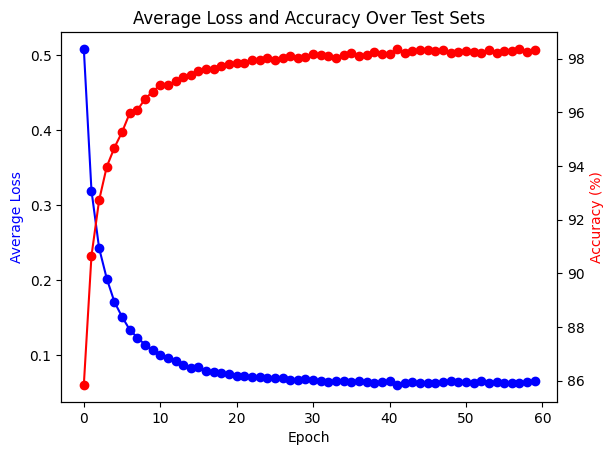

In [30]:
import matplotlib.pyplot as plt

# Data provided
data = {
    "Average Loss": loss_arr,
    "Accuracy": acc_arr  # Converting to percentage
}


# Create the figure and axis
fig, ax1 = plt.subplots()

# Plot Average Loss
ax1.plot(data["Average Loss"], 'bo-', label='Average Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Average Loss', color='b')

# Create another y-axis for Accuracy
ax2 = ax1.twinx()
ax2.plot(data["Accuracy"], 'ro-', label='Accuracy')
ax2.set_ylabel('Accuracy (%)', color='r')

# Add a title
plt.title('Average Loss and Accuracy Over Test Sets')

# Show the plot
plt.show()
